In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the CSV file
file_path = r"C:\Users\Beheerder\Documents\DSAI master\Q5 Courses\Research Topics in Data mining\Sample - Superstore.csv"

# Load the CSV file into a pandas DataFrame with specified encoding
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


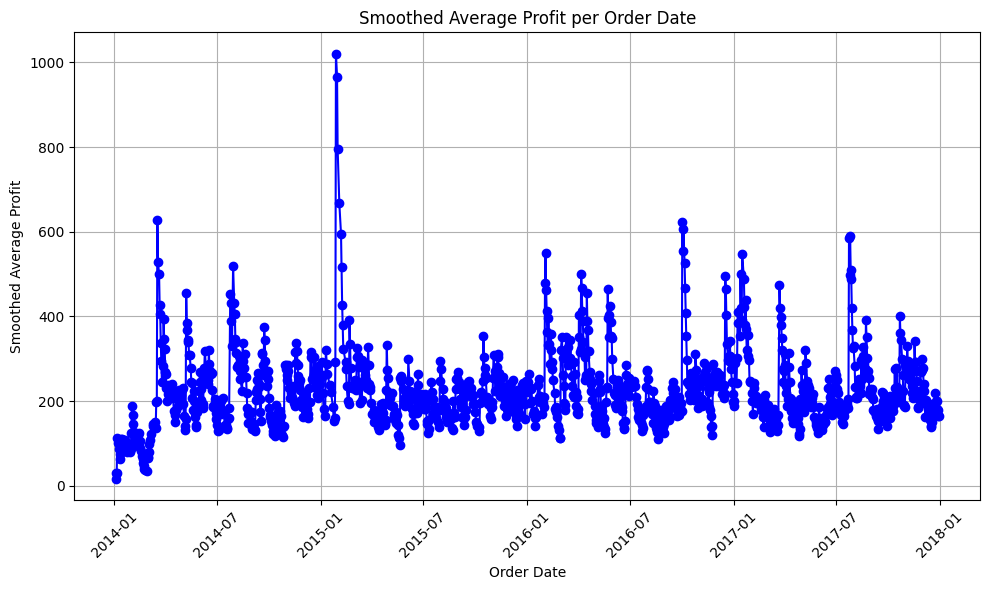

In [40]:

# Group by 'Order Date' and calculate the average profit per date
avg_profit_per_date = df.groupby('Order Date')['Sales'].mean()

# Apply exponential smoothing to the average profit per date
smoothed_profit_per_date = avg_profit_per_date.ewm(span=10, adjust=False).mean()

# Plot the smoothed data
plt.figure(figsize=(10,6))
plt.plot(smoothed_profit_per_date.index, smoothed_profit_per_date.values, marker='o', linestyle='-', color='b')
plt.title('Smoothed Average Profit per Order Date')
plt.xlabel('Order Date')
plt.ylabel('Smoothed Average Profit')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

In [70]:
import pandas as pd
import numpy as np
from itertools import product, combinations

# Define your quality measure functions
def entropy_quality(subgroup_size, total_size, rest_size):
    if subgroup_size == 0 or rest_size == 0:
        return 0  # Avoid NaN
    # Calculate entropy based on the formula given
    p_s = subgroup_size / total_size
    p_r = rest_size / total_size
    return -p_s * np.log(p_s) - p_r * np.log(p_r)

def distribution_difference(subgroup_data, rest_data, total_size):
    if rest_data == 0:
        return 0  # Avoid NaN
    # Use the third formula from your definition
    return (1 / total_size) * np.sum(np.abs((subgroup_data - rest_data) / rest_data))

def quality_measure(subgroup, df):
    # Total data size (unique people in the entire dataset)
    total_size = df['Customer ID'].nunique()
    
    # Subgroup size (unique people in the subgroup)
    subgroup_size = subgroup['Customer ID'].nunique()
    
    # Rest of the data size
    rest_size = total_size - subgroup_size
    
    # Apply exponential smoothing to 'Sales' for both subgroup and rest of the data
    smoothed_sales_subgroup = subgroup['Sales'].ewm(span=10, adjust=False).mean()
    smoothed_sales_rest = df.loc[~df.index.isin(subgroup.index), 'Sales'].ewm(span=10, adjust=False).mean()
    
    # Calculate entropy quality
    entropy = entropy_quality(subgroup_size, total_size, rest_size)
    
    # Calculate distribution difference in profit (smoothed sales)
    profit_subgroup = smoothed_sales_subgroup.mean()
    profit_rest = smoothed_sales_rest.mean()
    
    distribution_diff = distribution_difference(profit_subgroup, profit_rest, total_size)
    
    # Total quality measure
    return entropy * distribution_diff

# Subgroup discovery based on combinations of attribute values
def discover_subgroups(df, attributes, k=5):
    best_subgroups = []
    
    # Iterate over all possible subsets of attributes (including empty subset)
    for subset_length in range(1, len(attributes) + 1):
        for subset in combinations(attributes, subset_length):
            # Generate all possible combinations of attribute values for this subset of attributes
            attribute_values = [df[attribute].unique() for attribute in subset]
            all_combinations = list(product(*attribute_values))
            
            # Iterate over all combinations of attribute values
            for combination in all_combinations:
                # Create a boolean mask to filter the dataframe for this subgroup
                mask = np.ones(len(df), dtype=bool)
                subgroup_description = {}
                
                for i, attribute in enumerate(subset):
                    mask = mask & (df[attribute] == combination[i])
                    subgroup_description[attribute] = combination[i]
                
                # Define the subgroup using the mask
                subgroup = df[mask]
                
                # Only consider subgroups with at least one unique customer
                if subgroup['Customer ID'].nunique() > 0:
                    # Calculate the quality measure for the subgroup
                    quality = quality_measure(subgroup, df)
                    
                    # Append the subgroup with its attributes, quality, and unique size (based on Customer ID)
                    best_subgroups.append({
                        "Attributes": subgroup_description,  # Combination of attribute values
                        "Quality": quality,
                        "Group Size (Unique Customers)": subgroup['Customer ID'].nunique()
                    })
    
    # Sort the subgroups by quality in descending order and return the top k
    best_subgroups = sorted(best_subgroups, key=lambda x: x['Quality'], reverse=True)[:k]
    
    return best_subgroups


# Example: Subgroup discovery based on 'Sub-Category', 'Segment', 'Region', and 'Ship Mode'
attributes = ['Sub-Category', 'Segment', 'Region', 'Ship Mode']  # Variables for subgroup discovery
best_subgroups = discover_subgroups(df, attributes, k=200)

# Convert the list of dictionaries (best_subgroups) into a DataFrame for better visualization
subgroup_details_df = pd.DataFrame(best_subgroups)

# Display the entire DataFrame (all rows)
pd.set_option('display.max_rows', None)

# Print the entire DataFrame
print(subgroup_details_df)


                                            Attributes   Quality  \
0                         {'Sub-Category': 'Machines'}  0.003824   
1                          {'Sub-Category': 'Copiers'}  0.003140   
2    {'Sub-Category': 'Machines', 'Ship Mode': 'Sta...  0.003134   
3      {'Sub-Category': 'Machines', 'Region': 'South'}  0.002431   
4    {'Sub-Category': 'Machines', 'Segment': 'Consu...  0.002222   
5    {'Sub-Category': 'Copiers', 'Ship Mode': 'Stan...  0.002114   
6    {'Sub-Category': 'Machines', 'Segment': 'Consu...  0.002020   
7    {'Sub-Category': 'Machines', 'Region': 'Central'}  0.001722   
8    {'Sub-Category': 'Machines', 'Segment': 'Home ...  0.001698   
9    {'Sub-Category': 'Machines', 'Ship Mode': 'Sam...  0.001686   
10   {'Sub-Category': 'Copiers', 'Segment': 'Consum...  0.001622   
11                          {'Sub-Category': 'Tables'}  0.001615   
12      {'Sub-Category': 'Machines', 'Region': 'East'}  0.001565   
13   {'Sub-Category': 'Copiers', 'Segment': 'Hom

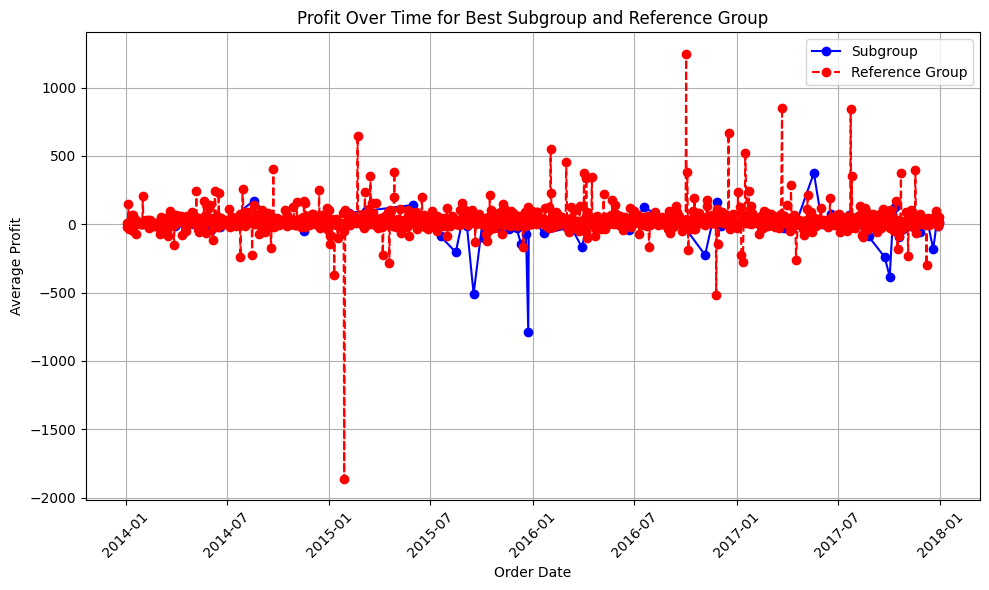

In [68]:
import matplotlib.pyplot as plt

# Find the best subgroup (the one with the highest quality measure)
best_subgroup = best_subgroups[40]  # The first in the sorted list

# Extract the subgroup description
subgroup_description = best_subgroup["Attributes"]

# Create a boolean mask to filter the dataframe for this best subgroup
mask = np.ones(len(df), dtype=bool)
for attribute, value in subgroup_description.items():
    mask = mask & (df[attribute] == value)

# Define the subgroup and the rest of the data (reference group)
subgroup = df[mask]
reference_group = df[~df.index.isin(subgroup.index)]

# Group by 'Order Date' and calculate the average 'Profit' per date for both the subgroup and reference group
subgroup_profit_per_date = subgroup.groupby('Order Date')['Profit'].mean()
reference_profit_per_date = reference_group.groupby('Order Date')['Profit'].mean()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(subgroup_profit_per_date.index, subgroup_profit_per_date.values, marker='o', linestyle='-', label='Subgroup', color='blue')
plt.plot(reference_profit_per_date.index, reference_profit_per_date.values, marker='o', linestyle='--', label='Reference Group', color='red')
plt.title('Profit Over Time for Best Subgroup and Reference Group')
plt.xlabel('Order Date')
plt.ylabel('Average Profit')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()


In [26]:
import pandas as pd

# Load the CSV file into a pandas DataFrame with specified encoding
file_path = r'C:\Users\Beheerder\Documents\DSAI master\Q5 Courses\Research Topics in Data mining\archive (2)\US_Regional_Sales_Data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['OrderDate'])

# Ensure correct data types
df['Order Quantity'] = df['Order Quantity'].astype(int)  # Order Quantity as integer
df['Discount Applied'] = df['Discount Applied'].astype(float)  # Discount as float

# Remove commas from 'Unit Price' and convert it to float
df['Unit Price'] = df['Unit Price'].str.replace(',', '').astype(float)

# Create a new column 'Revenue' as the product of Order Quantity, (1 - Discount Applied), and Unit Price
df['Revenue'] = (df['Order Quantity'] * (1 - df['Discount Applied']) * df['Unit Price']).astype(float)

# Display the first few rows to verify the new column and data types

df.head()  # To display the first few rows


C:\Users\Beheerder\AppData\Local\Temp\ipykernel_16300\3323014072.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order Date'] = pd.to_datetime(df['OrderDate'])


,ï»¿OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,_StoreID,_ProductID,Order Quantity,Discount Applied,Unit Cost,Unit Price,Order Date,Revenue
0,SO - 000101,In-Store,WARE-UHY1004,31/12/17,31/5/18,14/6/18,19/6/18,USD,6,15,259,12,5,0.075,"1,001.18",1963.1,2018-05-31,9079.3375
1,SO - 000102,Online,WARE-NMK1003,31/12/17,31/5/18,22/6/18,2/7/18,USD,14,20,196,27,3,0.075,"3,348.66",3939.6,2018-05-31,10932.3900
2,SO - 000103,Distributor,WARE-UHY1004,31/12/17,31/5/18,21/6/18,1/7/18,USD,21,16,213,16,1,0.050,781.22,1775.5,2018-05-31,1686.7250
3,SO - 000104,Wholesale,WARE-NMK1003,31/12/17,31/5/18,2/6/18,7/6/18,USD,28,48,107,23,8,0.075,"1,464.69",2324.9,2018-05-31,17204.2600
4,SO - 000105,Distributor,WARE-NMK1003,10/4/18,31/5/18,16/6/18,26/6/18,USD,22,49,111,26,8,0.100,"1,476.14",1822.4,2018-05-31,13121.2800


C:\Users\Beheerder\AppData\Local\Temp\ipykernel_16300\2081833063.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Order Date'] = pd.to_datetime(df['OrderDate'])


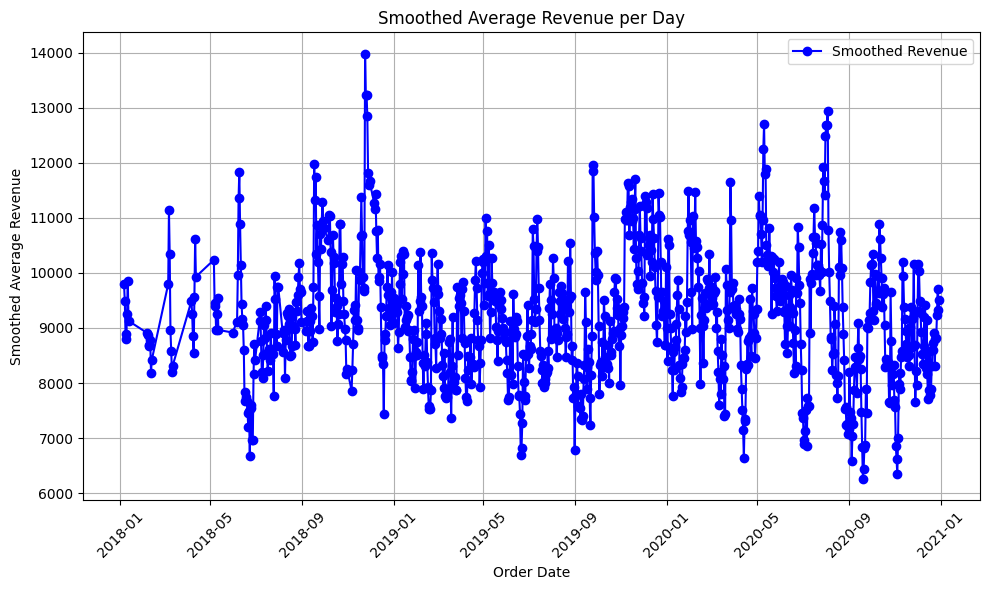

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame with specified encoding
file_path = r'C:\Users\Beheerder\Documents\DSAI master\Q5 Courses\Research Topics in Data mining\archive (2)\US_Regional_Sales_Data.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Convert 'Order Date' to datetime format
df['Order Date'] = pd.to_datetime(df['OrderDate'])

# Ensure correct data types
df['Order Quantity'] = df['Order Quantity'].astype(int)
df['Discount Applied'] = df['Discount Applied'].astype(float)
df['Unit Price'] = df['Unit Price'].str.replace(',', '').astype(float)

# Create the 'Revenue' column
df['Revenue'] = df['Order Quantity'] * (1 - df['Discount Applied']) * df['Unit Price']

# Group the data by 'Order Date' and calculate the average 'Revenue' per day
average_revenue_per_day = df.groupby('Order Date')['Revenue'].mean()

# Apply exponential smoothing to the average revenue per day
smoothed_revenue_per_day = average_revenue_per_day.ewm(span=10, adjust=False).mean()

# Create a plot for the smoothed average revenue per day
plt.figure(figsize=(10, 6))
plt.plot(smoothed_revenue_per_day.index, smoothed_revenue_per_day.values, marker='o', linestyle='-', color='blue', label='Smoothed Revenue')
plt.title('Smoothed Average Revenue per Day')
plt.xlabel('Order Date')
plt.ylabel('Smoothed Average Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [31]:
import pandas as pd
import numpy as np
from itertools import product

# Define your quality measure functions
def entropy_quality(subgroup_size, total_size, rest_size):
    # Calculate entropy based on the formula given
    p_s = subgroup_size / total_size
    p_r = rest_size / total_size
    return -p_s * np.log(p_s) - p_r * np.log(p_r)

def distribution_difference(subgroup_data, rest_data, total_size):
    # Use the third formula from your definition
    return (1 / total_size) * np.sum(np.abs((subgroup_data - rest_data) / rest_data))

def quality_measure(subgroup, df):
    # Total data size
    total_size = len(df)
    
    # Subgroup size
    subgroup_size = len(subgroup)
    
    # Rest of the data size
    rest_size = total_size - subgroup_size
    
    # Calculate entropy quality
    entropy = entropy_quality(subgroup_size, total_size, rest_size)
    
    # Calculate distribution difference in profit (example)
    profit_subgroup = subgroup['Order Quantity'].mean()
    profit_rest = df.loc[~df.index.isin(subgroup.index), 'Order Quantity'].mean()
    
    distribution_diff = distribution_difference(profit_subgroup, profit_rest, total_size)
    
    # Total quality measure
    return entropy * distribution_diff

# Subgroup discovery based on combinations of attribute values
def discover_subgroups(df, attributes, k=20):
    best_subgroups = []
    
    # Generate all possible combinations of attribute values
    attribute_values = [df[attribute].unique() for attribute in attributes]
    all_combinations = list(product(*attribute_values))
    
    # Iterate over all combinations of attribute values
    for combination in all_combinations:
        # Create a boolean mask to filter the dataframe for this subgroup
        mask = np.ones(len(df), dtype=bool)
        subgroup_description = {}
        
        for i, attribute in enumerate(attributes):
            mask = mask & (df[attribute] == combination[i])
            subgroup_description[attribute] = combination[i]
        
        # Define the subgroup using the mask
        subgroup = df[mask]
        
        # Calculate the quality measure for the subgroup
        quality = quality_measure(subgroup, df)
        
        # Append the subgroup with its attributes, quality, and size
        best_subgroups.append({
            "Attributes": subgroup_description,  # Combination of attribute values
            "Quality": quality,
            "Group Size": len(subgroup)
        })
    
    # Sort the subgroups by quality in descending order and return the top k
    best_subgroups = sorted(best_subgroups, key=lambda x: x['Quality'], reverse=True)[:k]
    
    return best_subgroups


# Example: Subgroup discovery based on 'Region', 'Segment', and 'Sub-Category'
attributes = ['Sales Channel', '_ProductID']  # Variables for subgroup discovery
best_subgroups = discover_subgroups(df, attributes, k=20)

# Convert the list of dictionaries (best_subgroups) into a DataFrame for better visualization
subgroup_details_df = pd.DataFrame(best_subgroups)

# Display the entire DataFrame (all rows)
pd.set_option('display.max_rows', None)

# Print the entire DataFrame
print(subgroup_details_df)



                                           Attributes       Quality  \
0        {'Sales Channel': 'Online', '_ProductID': 6}  7.020361e-07   
1       {'Sales Channel': 'Online', '_ProductID': 33}  6.795272e-07   
2       {'Sales Channel': 'Online', '_ProductID': 22}  6.690012e-07   
3     {'Sales Channel': 'In-Store', '_ProductID': 23}  6.623295e-07   
4     {'Sales Channel': 'In-Store', '_ProductID': 18}  6.555372e-07   
5      {'Sales Channel': 'In-Store', '_ProductID': 4}  6.481293e-07   
6        {'Sales Channel': 'Online', '_ProductID': 2}  6.371464e-07   
7   {'Sales Channel': 'Distributor', '_ProductID':...  6.348345e-07   
8   {'Sales Channel': 'Distributor', '_ProductID':...  6.342960e-07   
9     {'Sales Channel': 'In-Store', '_ProductID': 37}  6.335999e-07   
10      {'Sales Channel': 'Online', '_ProductID': 12}  5.850980e-07   
11  {'Sales Channel': 'Distributor', '_ProductID':...  5.775229e-07   
12  {'Sales Channel': 'Distributor', '_ProductID':...  5.445799e-07   
13    